In [1]:
import os
import xarray as xr

import chart_studio.plotly as py
from plotly.graph_objs import *
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
### open files day 2014 / 01 / 03
day = 20140104

### path contains dataset
path = 'data/radar/'

#read first file to extract static variable values
first_file = path+str(day)+'/'+str(os.listdir(path+str(day))[90])
    
try:
    xds = xr.open_dataset(first_file)   
except Exception as e:
    print('File not found')

In [3]:
lat = xds.lat0.data 
lon = xds.lon0.data 
rr = xds.rain_rate

In [4]:
trace1 = Contour(
    z=rr,
    x=lon,
    y=lat,
    colorscale="RdBu",
    zauto=False,  # custom contour levels
    zmin=-5,      # first contour level
    zmax=5        # last contour level  => colorscale is centered about 0
)

In [10]:
# Make trace-generating function (return a Scatter object)
def make_scatter(x,y):
    return Scatter(
        x=x,
        y=y,
        mode='lines',
        line=Line(color="black"),
        name=' '  # no name on hover
    )

# Functions converting coastline/country polygons to lon/lat traces
def polygons_to_traces(poly_paths, N_poly):
    ''' 
    pos arg 1. (poly_paths): paths to polygons
    pos arg 2. (N_poly): number of polygon to convert
    '''
    traces = []  # init. plotting list 

    for i_poly in range(N_poly):
        poly_path = poly_paths[i_poly]
        
        # get the Basemap coordinates of each segment
        coords_cc = np.array(
            [(vertex[0],vertex[1]) 
             for (vertex,code) in poly_path.iter_segments(simplify=False)]
        )
        
        # convert coordinates to lon/lat by 'inverting' the Basemap projection
        lon_cc, lat_cc = m(coords_cc[:,0],coords_cc[:,1], inverse=True)
        
        # add plot.ly plotting options
        traces.append(make_scatter(lon_cc,lat_cc))
     
    return traces

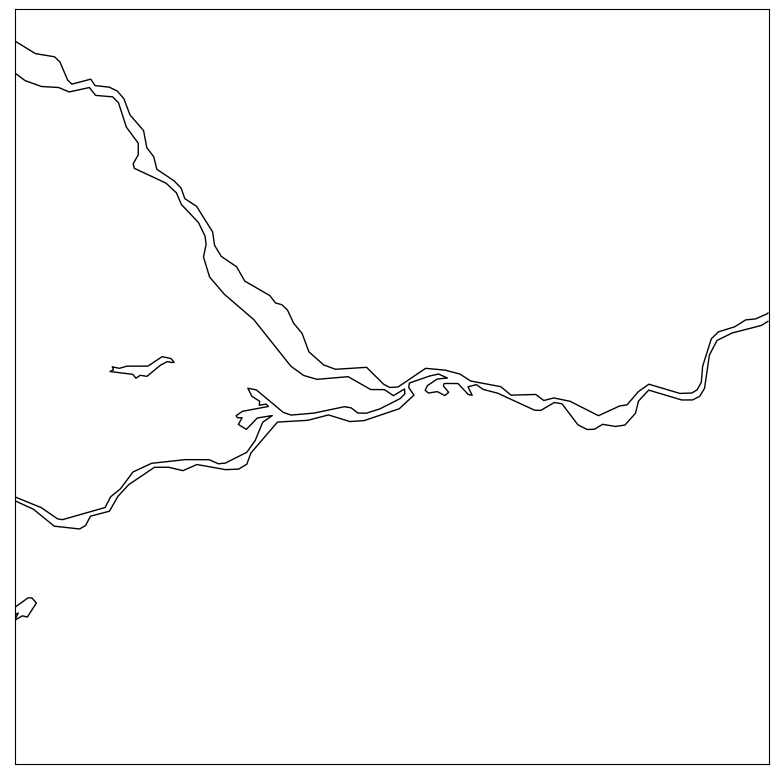

In [12]:
my_coords = [-3.148556, -59.992000]     ## RADAR T1 SIPAM COORDS
zoom_scale = 2.2                        ## ZOOM SCALE

bbox = [my_coords[0]-zoom_scale,my_coords[0]+zoom_scale,\
             my_coords[1]-zoom_scale,my_coords[1]+zoom_scale]


fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(10,10),dpi=100)
label = 'Rain rate in '
title = 'SIPAM Manaus S-Band Radar :'

    # draw filled contours.
clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
                 50, 70, 100]

cmap_data = [(1.0, 1.0, 1.0),
                     (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
                     (0.0, 1.0, 1.0),
                     (0.0, 0.8784313797950745, 0.501960813999176),
                     (0.0, 0.7529411911964417, 0.0),
                     (0.501960813999176, 0.8784313797950745, 0.0),
                     (1.0, 1.0, 0.0),
                     (1.0, 0.6274510025978088, 0.0),
                     (1.0, 0.0, 0.0),
                     (1.0, 0.125490203499794, 0.501960813999176),
                     (0.9411764740943909, 0.250980406999588, 1.0),
                     (0.501960813999176, 0.125490203499794, 1.0),
                     (0.250980406999588, 0.250980406999588, 1.0)]

cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
norm = mcolors.BoundaryNorm(clevs, cmap.N)
ax = axes

m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
                    llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')

## PRECIPTACAO
xi, yi = m(lon, lat)
# cs = m.pcolormesh(xi,yi,rr, cmap = cmap, norm = norm, ax=ax)

# # # # Add Grid Lines
# m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0],rotation=45, size=(7))
# m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45, size=(7))
# m.drawmapboundary(fill_color='gray')

# Function generating coastline lon/lat traces
def get_coastline_traces():
    poly_paths = m.drawcoastlines().get_paths() # coastline polygon paths
    N_poly = 6  # use only the 91st biggest coastlines (i.e. no rivers)
    return polygons_to_traces(poly_paths, N_poly)

# Function generating country lon/lat traces
def get_country_traces():
    poly_paths = m.drawcountries().get_paths() # country polygon paths
    N_poly = len(poly_paths)  # use all countries
    return polygons_to_traces(poly_paths, N_poly)

# # Get list of of coastline and country lon/lat traces
traces_cc = get_coastline_traces()+get_country_traces()

In [13]:
data = Data([trace1]+traces_cc)

title = u"Average daily surface air temperature anomalies [\u2103]<br> \
in July 2014 with respect to 1981-2010 climatology"

anno_text = "Data courtesy of \
<a href='http://www.esrl.noaa.gov/psd/data/composites/day/'>\
NOAA Earth System Research Laboratory</a>"

axis_style = dict(
    zeroline=False,
    showline=False,
    showgrid=False,
    ticks='',
    showticklabels=False,
)

layout = Layout(
    title=title,
    showlegend=False,
    hovermode="closest",        # highlight closest point on hover
    xaxis=XAxis(
        axis_style,
        range=[lon[0],lon[-1]]  # restrict y-axis to range of lon
    ),
    yaxis=YAxis(
        axis_style,
    ),
    annotations=Annotations([
        Annotation(
            text=anno_text,
            xref='paper',
            yref='paper',
            x=0,
            y=1,
            yanchor='bottom',
            showarrow=False
        )
    ]),
    autosize=False,
    width=500,
    height=250,
)

/ssd/miniconda3/envs/cap394/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:40: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.


/ssd/miniconda3/envs/cap394/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:550: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis


/ssd/miniconda3/envs/cap394/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:578: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis


/ssd/miniconda3/envs/cap394/lib/python3.6/site-pa

In [14]:
fig = Figure(data=data, layout=layout)

py.iplot(fig, filename="maps", width=100)

PlotlyRequestError: Authentication credentials were not provided.